# The Diet Problem

This file is a slightly modified version of Pyomo Gallary Diet Problem example from https://github.com/Pyomo/PyomoGallery/wiki

## Summary

The goal of the Diet Problem is to select foods that satisfy daily nutritional requirements at minimum cost. This problem can be formulated as a linear program, for which constraints limit the number of calories and the amount of vitamins, minerals, fats, sodium, and cholesterol in the diet. Danzig (1990) notes that the diet problem was motivated by the US Army's desire to minimize the cost of feeding GIs in the field while still providing a healthy diet.

## Problem Statement

The Diet Problem can be formulated mathematically as a linear programming problem using the following model.  

### Sets

* $F$ = set of foods  
* $N$ = set of nutrients

### Parameters

* $c_i$ = cost per serving of food $i$, where $i \in F$  
* $a_{ij}$ = amount of nutrient $j$ in food $i$, where $i \in F$ and  $j \in N$  
* $N^\min_j$ = minimum level of nutrient $j$, where $j \in N$  
* $N^\max_j$ = maximum level of nutrient $j$, where $j \in N$  
* $V_i$ = the volume per serving of food $i$, where $i \in F$  
* $V_\max$ = maximum volume of food consumed
 
### Decision Variables

* $x_i$ = number of servings of food $i$ to consume

### Objective

Minimize the total cost of the food  
$$
 \text{minimize} \sum_{i \in F} c_i x_i
$$

### Constraints

Limit nutrient consumption for each nutrient $j \in N$:
$$
 N^\min_j \leq \sum_{i \in F} a_{ij} x_i \leq N^\max_j
$$
for each $j \in N$.

Limit the volume of food consumed:
$$
  \sum_{i \in F} V_i x_i \leq V_\max
$$
 
We cannot consume negative amounts of food:
$$
 x_i \geq 0
$$
for each $i \in F$.

## Pyomo Formulation

We formulate this problem as an abstract Pyomo model, i.e. we specify the sets, parameters, and variables.  The concrete values are contained in a separate file.

In [1]:
from pyomo.environ import *
from pyomo.opt import *
infinity = float('inf')

model = AbstractModel()

The sets $F$ and $N$ are declared abstractly using the `Set` component:

In [2]:
# Foods
model.F = Set()
# Nutrients
model.N = Set()

Similarly, the model parameters are defined abstractly using the `Param` component:

In [3]:
# Cost of each food
model.c    = Param(model.F, within=PositiveReals)
# Amount of nutrient in each food
model.a    = Param(model.F, model.N, within=NonNegativeReals)
# Lower and upper bound on each nutrient
model.Nmin = Param(model.N, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.N, within=NonNegativeReals, default=infinity)
# Volume per serving of food
model.V    = Param(model.F, within=PositiveReals)
# Maximum volume of food consumed
model.Vmax = Param(within=PositiveReals)

The `within` option is used in these parameter declarations to define expected properties of the parameters.  This information is used to perform error checks on the data that is used to initialize the parameter components.

The `Var` component is used to define the decision variables:

In [4]:
# Number of servings consumed of each food
model.x = Var(model.F, within=NonNegativeIntegers)

The `within` option is used to restrict the domain of the decision variables to the non-negative integers, as we want to construct a diet from menu items from a fast food restaurant.

The `Objective` component is used to define the cost objective.  This component uses a rule function to construct the objective expression:

In [5]:
# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.F)
model.cost = Objective(rule=cost_rule)

Similarly, rule functions are used to define constraint expressions in the `Constraint` component:

In [6]:
# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.a[i,j]*model.x[i] for i in model.F)
    return model.Nmin[j] <= value <= model.Nmax[j]
model.nutrient_limit = Constraint(model.N, rule=nutrient_rule)

# Limit the volume of food consumed
def volume_rule(model):
    return sum(model.V[i]*model.x[i] for i in model.F) <= model.Vmax
model.volume = Constraint(rule=volume_rule)

## Model Data

Since this is an abstract Pyomo model, the set and parameter values need to be provided to initialize the model.  The data file `diet.dat` is a synthetic example for the problem of designing a daily diet with only food from a fast food chain.


## Solution

We create an instance of the model using the data from `diet.dat`:

In [7]:
instance = model.create_instance('diet.dat')

Now choose the `glpk` solver and solve the instance.

In [8]:
opt = solvers.SolverFactory("glpk")
results = opt.solve(instance)

Let's first look at the optimal cost:

In [9]:
instance.cost.expr()

15.05

To visualize the optimal diet, we draw a bar chart.  This is done using _matplotlib_ plotting, part of the _pylab_ interactive scientific computing environment.  Let's first import _pylab_, the `inline` keyword switches to placing graphs inline into the notebook.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


First extract the optimal values of the decision variables from the instance.

In [11]:
res = instance.x.get_values()

Now let's draw a horizontal bar chart (`barh`).  The `align='center'` option centers the bars relative to the labels.  We then use the full text for each of the foods as tick labels on the $y$-axis.

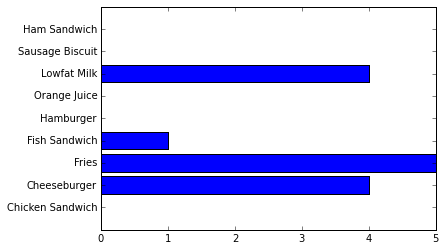

In [12]:
barh(range(len(res)),res.values(), align='center')
yticks(range(len(res)), list(res.keys()));

This solution shows that for about $15 per day, a person can get by with 4 
cheeseburgers, 5 fries, 1 fish sandwich and 4 milks.

## References

* G.B. Dantzig. _The Diet Problem_, Interfaces 20(4), 1990, 43-47